In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [4]:
# adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/slideseq_mouse_lymphnode.h5ad')
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 22919 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

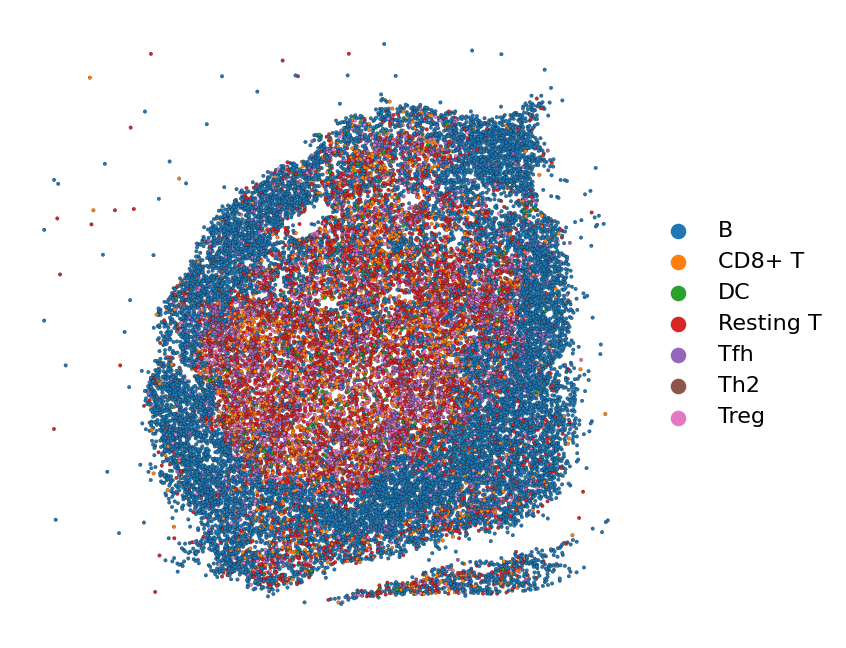

In [5]:
plt.rcParams["figure.figsize"] = (5, 5)
plt.rcParams['figure.dpi'] = 160
sc.pl.embedding(adata, basis='spatial', color='cell_type', 
    frameon=False, edgecolor='black', s=10, linewidth=0.1, title='')

In [6]:
import jscatter
import numpy as np

x = adata.obsm['spatial'][:, 0]
y = adata.obsm['spatial'][:, 1]
c = adata.obs['cell_type'].values

scatter = jscatter.Scatter(x, y, color_by=c, height=600, width=600)
scatter.show()

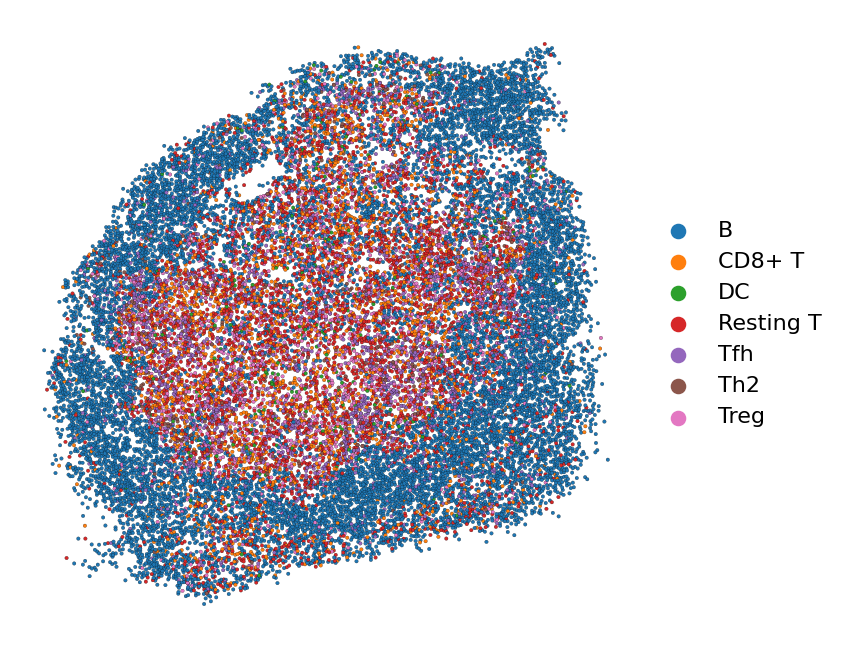

In [7]:
sc.pl.embedding(adata[scatter.selection()], basis='spatial', color='cell_type', 
    frameon=False, edgecolor='black', s=10, linewidth=0.1, title='')

In [8]:
adata[scatter.selection()].obs['cell_type'].value_counts()

cell_type
B            11832
Resting T     3660
Tfh           2095
CD8+ T        2015
Treg          1771
Th2            632
DC             222
Name: count, dtype: int64

In [9]:
adata = adata[scatter.selection()]

In [10]:
adata.write_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')

In [40]:
import sys
sys.path.append('../../src/')

In [41]:
import celloracle as co

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams['figure.dpi'] = 180

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [42]:
%%time

sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X')
sc.tl.umap(adata)
# sc.tl.leiden(adata, resolution=0.5)

CPU times: user 54.4 s, sys: 9.03 s, total: 1min 3s
Wall time: 44.3 s


In [45]:
adata.X.max()

521.0

In [46]:
adata.layers["raw_count"].max()

521.0

In [67]:
oracle = co.Oracle()

adata.X = adata.layers["raw_count"].copy()

oracle.import_anndata_as_raw_count(
    adata=adata,
    cluster_column_name="cell_type",
    embedding_name="X_umap"
)

oracle.pcs = [True]
oracle.k_knn_imputation = 1
oracle.knn = 1

In [68]:
base_GRN = co.data.load_mouse_promoter_base_GRN()
oracle.import_TF_data(TF_info_matrix=base_GRN)

Loading prebuilt promoter base-GRN. Version: mm10_gimmemotifsv5_fpr2


In [69]:
%%time

links = oracle.get_links(
    cluster_name_for_GRN_unit="cell_type", 
    alpha=5,
    verbose_level=1
)

100%|██████████| 7/7 [10:32<00:00, 90.29s/it] 

CPU times: user 5min 15s, sys: 22.7 s, total: 5min 38s
Wall time: 10min 32s


In [70]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(
    alpha=5, 
    use_cluster_specific_TFdict=True
)

  0%|          | 0/7 [00:00<?, ?it/s]

In [71]:
import pickle

with open('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode_colinks.pkl', 'wb') as f:
    pickle.dump(links.links_dict, f)

In [20]:

oracle.to_hdf5("/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.celloracle.oracle")
links.to_hdf5(file_path="/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.celloracle.links")